In [10]:
import os 
import time 
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Callable, Optional, Type, Union
from functools import partial

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models

from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchvision import datasets

import torch.optim as optim
import csv
from tqdm import tqdm 
import time as time

torch.manual_seed(42)

In [12]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure all images are 32x32
    transforms.ToTensor(),
])

# Download and create the CIFAR-10 train and test datasets
train_ds = torchvision.datasets.CIFAR10(
    root='./', train=True, download=True, transform=transform
)

test_ds = torchvision.datasets.CIFAR10(
    root='./', train=False, download=True, transform=transform
)

print(f'Train Samples: {len(train_ds)} || Test Samples: {len(test_ds)} || Classes: {len(train_ds.classes)}')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Train Samples: 50000 || Test Samples: 10000 || Classes: 10


In [6]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_chans: int, out_chans: int, kernel_size: int, stride: int, padding: int):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_chans, in_chans, kernel_size=kernel_size, stride=stride,
                                   padding=padding, groups=in_chans, bias=False)
        self.pointwise = nn.Conv2d(in_chans, out_chans, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class PostNormAttention(nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        kernel_size: int = 3
    ):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)
        self.proj = nn.Linear(dim, dim)
        
        # Depthwise convolution
        self.depthwise_conv = DepthwiseSeparableConv(dim, dim, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
                
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, P, C = x.shape
        H = self.num_heads
        
        q = self.q(x).view(B, P, H, -1).transpose(1, 2)
        k = self.k(x).view(B, P, H, -1).transpose(1, 2)
        v = self.v(x).view(B, P, H, -1).transpose(1, 2)
        
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        
        x_reshaped = x.transpose(1, 2).view(B, C, int(P**0.5), int(P**0.5))
        conv_out = self.depthwise_conv(x_reshaped)
        
        self.conv_feature_maps = conv_out.detach()  # Store conv feature maps for visualization
        
        conv_out = conv_out.view(B, C, P).transpose(1, 2)
        
        x = attn @ v
        x = x.transpose(1, 2).reshape(B, P, C)
        x = x + conv_out
        
        x = F.layer_norm(x, [C])
        x = self.proj(x)
        return x

class PatchEmbed(nn.Module):
    def __init__(self,
                 img_size: int,
                 patch_size: int,
                 in_chans: int,
                 embed_dim: int,
    ):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (self.img_size // self.patch_size, ) * 2
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(in_chans,
                              embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size,
                              padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)
        return x

class PositionalEmbedding(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super().__init__()
        self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.position_embeddings

class Attention(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int, embed_dim: int, num_heads: int):
        super().__init__()
        
        self.patch_embed = PatchEmbed(img_size, patch_size, in_channels, embed_dim)
        self.positional_embedding = PositionalEmbedding(self.patch_embed.num_patches, embed_dim)
        self.combined_attn = PostNormAttention(embed_dim, num_heads)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.patch_embed(x)  # Shape: (B, num_patches, embed_dim)
        x = self.positional_embedding(x)
        x = self.combined_attn(x)  # Shape: (B, num_patches, embed_dim)

        return x
    
class PostNormAttentionModel(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int, embed_dim: int, num_heads: int, classes: int = 10):
        super().__init__()     
        self.attn = Attention(img_size, patch_size, in_channels, embed_dim, num_heads)
        
        num_patches = (img_size // patch_size) ** 2
        self.fc = nn.Linear(num_patches * embed_dim, classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.attn(x)
        B, P, C = x.shape
        
        x = x.view(B, -1)
        x = self.fc(x)
        return x

In [7]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_step(model, dataloader, criterion, optimizer, device):
    '''Train for one epoch'''
    
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(dataloader):
       
        X, y = data[0].to(device), data[1].to(device)
        
        logits = model(X)
        loss = criterion(logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.argmax(logits.detach(), dim=1)
        train_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rTraining: [{i+1}/{len(dataloader)}] '
              f'Loss: {train_loss / (i + 1):.4f} '
              f'Acc: {train_acc / (i + 1):.4f}', end='')

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return train_loss, train_acc

@torch.inference_mode()
def eval_step(model, dataloader, criterion, device):
    '''Evaluate the model'''
    
    model.eval()

    eval_loss = 0.0
    eval_acc = 0.0

    for i, data in enumerate(dataloader):

        X, y = data[0].to(device), data[1].to(device)
        
        logits = model(X)
        loss = criterion(logits, y)
        eval_loss += loss.item()

        y_pred = torch.argmax(logits.detach(), dim=1)
        eval_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rEvaluation: [{i+1}/{len(dataloader)}] '
              f'Loss: {eval_loss / (i + 1):.4f} '
              f'Acc: {eval_acc / (i + 1):.4f}', end='')

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return eval_loss, eval_acc

In [13]:
model = PostNormAttentionModel(img_size=32, patch_size=8, in_channels=3, embed_dim=784, num_heads=16, classes=10)

out_dir = '../working/attn-output'
os.makedirs(out_dir, exist_ok=True)
epochs = 10
lr = 3e-4
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

bar_format = '{l_bar}{bar} | Epoch: {n_fmt}/{total_fmt} | Time: {elapsed} < {remaining} | {rate_fmt}'
model.to(device)

params = count_trainable_params(model)
print(f'Finetuning {params*1e-6:.3f}M params on {device} for {epochs} epochs ...\n')

csv_file = os.path.join(out_dir, 'log.csv')
model_file = os.path.join(out_dir, 'weights.pth')

with open(csv_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])

    for epoch in tqdm(range(epochs), desc="Epochs", bar_format=bar_format, leave=True):
        start_time = time.time()  

        train_loss, train_acc = train_step(model, train_dl, criterion, optimizer, device)
        val_loss, val_acc = eval_step(model, test_dl, criterion, device)
        
        writer.writerow([epoch+1, train_loss, train_acc, val_loss, val_acc])
        
        epoch_duration = time.time() - start_time

        tqdm.write(f"============ Epoch {epoch + 1} --> Train Acc: {train_acc:.4f} || Val Acc: {val_acc:.4f} || Time: {epoch_duration:.2f} s ============\n")
    
    torch.save(model.state_dict(), model_file)

Finetuning 2.759M params on cuda for 10 epochs ...



Epochs:   0%|           | Epoch: 0/10 | Time: 00:00 < ? | ?it/s

Training: [1563/1563] Loss: 1.7086 Acc: 0.3897
Evaluation: [309/313] Loss: 1.5308 Acc: 0.4508

Epochs:  10%|█          | Epoch: 1/10 | Time: 00:12 < 01:56 | 12.89s/it

Evaluation: [313/313] Loss: 1.5312 Acc: 0.4495
============ Epoch 1 --> Train Acc: 0.3897 || Val Acc: 0.4495 || Time: 12.89 s ============

Training: [1563/1563] Loss: 1.4886 Acc: 0.4674
Evaluation: [296/313] Loss: 1.4370 Acc: 0.4832

Epochs:  20%|██         | Epoch: 2/10 | Time: 00:25 < 01:39 | 12.49s/it

Evaluation: [313/313] Loss: 1.4378 Acc: 0.4815
============ Epoch 2 --> Train Acc: 0.4674 || Val Acc: 0.4815 || Time: 12.21 s ============

Training: [1563/1563] Loss: 1.3960 Acc: 0.5007
Evaluation: [306/313] Loss: 1.3690 Acc: 0.5112

Epochs:  30%|███        | Epoch: 3/10 | Time: 00:37 < 01:26 | 12.40s/it

Evaluation: [313/313] Loss: 1.3714 Acc: 0.5097
============ Epoch 3 --> Train Acc: 0.5007 || Val Acc: 0.5097 || Time: 12.28 s ============

Training: [1563/1563] Loss: 1.3225 Acc: 0.5283
Evaluation: [300/313] Loss: 1.3999 Acc: 0.5082

Epochs:  40%|████       | Epoch: 4/10 | Time: 00:49 < 01:13 | 12.23s/it

Evaluation: [313/313] Loss: 1.4042 Acc: 0.5061
============ Epoch 4 --> Train Acc: 0.5283 || Val Acc: 0.5061 || Time: 11.97 s ============

Training: [1563/1563] Loss: 1.2622 Acc: 0.5518
Evaluation: [311/313] Loss: 1.4215 Acc: 0.4982

Epochs:  50%|█████      | Epoch: 5/10 | Time: 01:01 < 01:01 | 12.25s/it

Evaluation: [313/313] Loss: 1.4218 Acc: 0.4976
============ Epoch 5 --> Train Acc: 0.5518 || Val Acc: 0.4976 || Time: 12.27 s ============

Training: [1563/1563] Loss: 1.2129 Acc: 0.5695
Evaluation: [304/313] Loss: 1.3238 Acc: 0.5347

Epochs:  60%|██████     | Epoch: 6/10 | Time: 01:14 < 00:49 | 12.29s/it

Evaluation: [313/313] Loss: 1.3282 Acc: 0.5322
============ Epoch 6 --> Train Acc: 0.5695 || Val Acc: 0.5322 || Time: 12.37 s ============

Training: [1563/1563] Loss: 1.1654 Acc: 0.5871
Evaluation: [304/313] Loss: 1.3525 Acc: 0.5345

Epochs:  70%|███████    | Epoch: 7/10 | Time: 01:26 < 00:36 | 12.28s/it

Evaluation: [313/313] Loss: 1.3551 Acc: 0.5331
============ Epoch 7 --> Train Acc: 0.5871 || Val Acc: 0.5331 || Time: 12.25 s ============

Training: [1563/1563] Loss: 1.1148 Acc: 0.6077
Evaluation: [313/313] Loss: 1.3252 Acc: 0.5444

Epochs:  80%|████████   | Epoch: 8/10 | Time: 01:38 < 00:24 | 12.34s/it


============ Epoch 8 --> Train Acc: 0.6077 || Val Acc: 0.5444 || Time: 12.46 s ============

Training: [1563/1563] Loss: 1.0703 Acc: 0.6221
Evaluation: [302/313] Loss: 1.3512 Acc: 0.5505

Epochs:  90%|█████████  | Epoch: 9/10 | Time: 01:50 < 00:12 | 12.29s/it

Evaluation: [313/313] Loss: 1.3567 Acc: 0.5480
============ Epoch 9 --> Train Acc: 0.6221 || Val Acc: 0.5480 || Time: 12.19 s ============

Training: [1563/1563] Loss: 1.0254 Acc: 0.6386
Evaluation: [301/313] Loss: 1.3833 Acc: 0.5361

Epochs: 100%|██████████ | Epoch: 10/10 | Time: 02:03 < 00:00 | 12.33s/it

Evaluation: [313/313] Loss: 1.3896 Acc: 0.5347
============ Epoch 10 --> Train Acc: 0.6386 || Val Acc: 0.5347 || Time: 12.41 s ============



In [ ]:
def get_attention_map(img):
    patches = model.attn.patch_embed(img)
    patches = model.attn.positional_embedding(patches)

    q_weights = model.attn.combined_attn.q.weight.data
    k_weights = model.attn.combined_attn.k.weight.data

    queries = patches @ q_weights  # Shape: (B, num_patches, embed_dim)
    keys = patches @ k_weights.T   # Shape: (B, num_patches, embed_dim)

    # Reshape and transpose queries and keys to (B, H, P, head_dim)
    B, P, _ = queries.shape
    H = model.attn.combined_attn.num_heads
    head_dim = queries.shape[-1] // H

    queries = queries.view(B, P, H, head_dim).transpose(1, 2)
    keys = keys.view(B, P, H, head_dim).transpose(1, 2)
    attn_scores = ((queries @ keys.transpose(-2, -1)) * (head_dim ** -0.5)).view(B, H, -1)  # Shape: (B, H, P*P)

    # Compute attention map using softmax and averaging over heads
    attn_map = attn_scores.softmax(dim=-1)
    attn_map = attn_map.view(B, H, P, P)
    attn_map = torch.mean(attn_map, dim=1)  # Shape: (B, P, P)

    attention_map = attn_map.squeeze(0).detach().cpu().numpy()  # Shape: (P, P)

    img_np = img[0].permute(1, 2, 0).cpu().numpy()
    
    return img_np

def get_feature_map(img):
    conv_out = model.attn.combined_attn.depthwise_conv(img)
    
    random_channel = torch.randint(0, num_channels, ()).item()
    conv_feature_map = conv_out[random_channel].cpu().numpy()
    
    return conv_feature_map

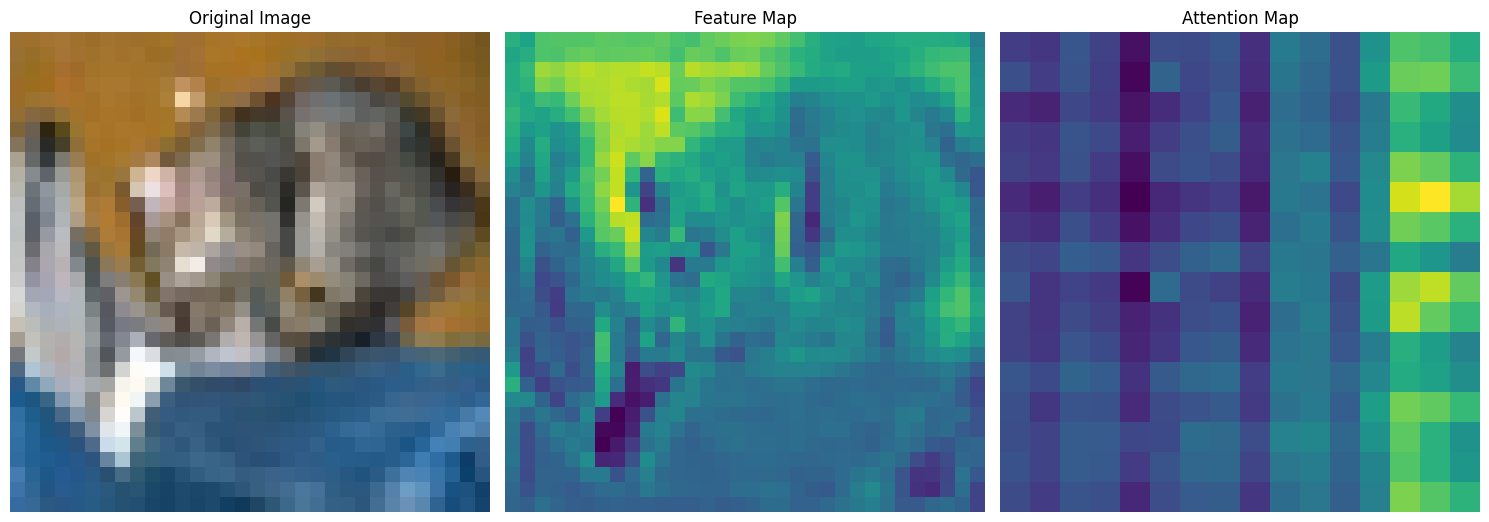

<Figure size 640x480 with 0 Axes>

In [19]:
# Visualization function
def visualize_feature_maps(original, final, attention_map):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    
    # Original image
    axs[0].imshow(original.squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    axs[0].set_title('Original Image')
        
    # Final output
    axs[1].imshow(final[0, 0].detach().numpy(), cmap='viridis')
    axs[1].set_title('Feature Map')
    
    axs[2].imshow(attention_map, cmap='viridis')
    axs[2].set_title('Attention Map')
    
    for ax in axs.flat:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    plt.savefig('../working/task6_2.png')

# Visualize the results
images, labels = next(iter(test_dl))  
classes = test_ds.classes

image, label = images[0].unsqueeze(0).to(device), classes[labels[0].item()]  
attention_map = get_attention_map(image)
feature_map = get_feature_map(image)
visualize_feature_maps(image, final_out, attention_map)